# Mapping fire damage from the wildfires in Larache Province, Morocco, in 2022 using Sentinel-2 Normalised Burn Ratio (NBR) and differenced NBR1


# Connecting to  Google Drive from Colab.

In [1]:
# Loading the Drive helper and mount your Google Drive as a drive in the virtual machine
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing all required libraries

In [2]:
# Installing some libraries that are not on Colab by default
!pip install rasterio
!pip install geopandas
!pip install rasterstats
!pip install earthengine-api
!pip install requests
!pip install sentinelsat

# Importing libraries
import geopandas as gpd
import rasterio
from rasterio import plot
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, ogr, osr
import json
import os
from os import listdir
from os.path import isfile, isdir, join
import math
from pprint import pprint
import shutil
import sys
import zipfile
import requests
import io
import webbrowser
import ee
import pandas as pd
import rasterio.mask
import xarray as xr
import matplotlib.colors as colors
import matplotlib
import glob
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping

'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# defining the root directory where our data are to be stored 
rootdir = '/content/drive/MyDrive/satelliteCW1' # this is where pygge.py is saved on my Google Drive

if rootdir not in sys.path:
    sys.path.append(rootdir)
# importing the pygge library of functions for this module
import pygge

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 64.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: fiona
    Found existing installation: Fiona 1.9.3
    Uninstalling Fiona-1.9.3:
      Successfully uninstalled Fiona-1.9.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/co

# Setting up some directory paths on Google Drive


 A shapefile of Larache province is in my Google Drive.  I drew a polygon and saved it as a shapefile on http://www.geojson.io.

In [3]:
# Connecting to Google Earth Engine API
# This opens a web page where i  enter my account information and a verification code is also provided. This code is what i paste into the terminal.
!earthengine authenticate

ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=ju3b_5XUCd26BnSaUOy1CSPMOfYpma8S4yzRRvfrdVI&tc=N0AMAGBIMojVZXPwPBIGJ-tzdfwFVnRLWX9ydXYtNSo&cc=TfEFLqMQopvnfp-Le-1fTSgLjv7AjaG21tDr2-zyP6A

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk7G8EgNV0_9iMuMqH4Tp-rPZ7SqnoWcDzlY-x8EMFyjGzntJt32T6Y

Successfully saved authorization token.


In [4]:
'''
--------------------------------------------------------------
The following block of code originates  from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''

# set up your directories for the satellite data
# Note that we do all the downloading and data analysis on the temporary drive
#    on Colab. We will copy the output directory to our Google Drive at the end.
#    Colab has more disk space (about 40 GB free space) than Google Drive (15 GB).
#    However, the data on the Colab disk space are NOT kept when you log out.

# path to your Google Drive
print("Connected to data directory: " + rootdir)

# path to your temporary drive on the Colab Virtual Machine. This will be removed
#   when the session ends.
cd = "/content/work"

# directory for downloading the Sentinel-2 composites
# Note that we are using the 'join' function imported from the os library here
# It is an easy way of merging strings into a directory structure.
# It is clever and chooses the / or \ depending on whether you are on Windows or Linux.
downloaddir = join(cd, 'download') # where we save the downloaded images

# CAREFUL: This code removes the named directories and everything inside them to free up space
# Because the downloaddir is in your temporary drive, it should be empty at the
#    start of the session.
# Note: shutil provides a lot of useful functions for file and directory management
try:
  shutil.rmtree(downloaddir)
except:
  print(downloaddir + " not found.")

# create the new directories, unless they already exist
os.makedirs(cd, exist_ok=True)
os.makedirs(downloaddir, exist_ok=True)

print("Connected to Colab temporary data directory: " + cd)

print("\nList of contents of " + rootdir)
for f in sorted(os.listdir(rootdir)):
  print(f)

Connected to data directory: /content/drive/MyDrive/satelliteCW1
/content/work/download not found.
Connected to Colab temporary data directory: /content/work

List of contents of /content/drive/MyDrive/satelliteCW1
.ipynb_checkpoints
229010645_GY7709_CW1 BACKUP2.ipynb
229010645_GY7709_CW1 BACKUP3.ipynb
229010645_GY7709_CW1.html
229010645_GY7709_CW1.ipynb
229010645_GY7709_CW1_backup.ipynb
229010645_GY7709_CW1_original.html
NBR_larache_after.tiff
NBR_larache_before.tiff
NDVI_larache_after.tiff
NDVI_larache_before.tiff
__pycache__
backup
burned_layers
dNBR.tif
dNBR.tiff
dNBR_warped.tif
larache_after
larache_before
larache_before_fire.tif
larache_before_fire_warped.tif
larache_new_shapefile
larache_shapefiles
leicestershire
oakham
practical_week32_SentinelSat.ipynb
pygge.ipynb
pygge.py
sencredentials.txt
taza
unburned_layers


# Defining search parameters for the before fire image of Larache

 modifying some of the parameters and uploading the shapefile of Larache called "POLYGON.shp" .

In [5]:
'''
--------------------------------------------------------------
The following block of code  is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# EDITING THE SEARCH OPTIONS BELOW

shapefile = join(rootdir, 'larache_new_shapefile', 'FULL_POLYGON.shp') # ESRI Shapefile of the study area

# checking whether the shapefile exists
if os.path.exists(shapefile):
  print('Shapefile found: '+shapefile)
else:
  print('ERROR: Shapefile not found: '+shapefile)
  print('Upload a shapefile to your Google Drive directory: '+ rootdir)

# Defining a date range for the search
datefrom = '2022-07-01' # start date for imagery search
dateto   = '2022-07-10' # end date for imagery search
time_range = [datefrom, dateto] # format as a list

# Defining which cloud cover percentage we accept in the images
clouds = 8 # maximum acceptable cloud cover in 

Shapefile found: /content/drive/MyDrive/satelliteCW1/larache_new_shapefile/FULL_POLYGON.shp


# Getting some information about the shapefile.

In [6]:
'''
--------------------------------------------------------------
The following block of code originates from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# Getting the shapefile layer's extent, CRS and EPSG code
extent, outSpatialRef, epsg = pygge.get_shp_extent(shapefile)
print("Extent of the area of interest (shapefile):\n", extent)
print(type(extent))
print("\nCoordinate referencing system (CRS) of the shapefile:\n", outSpatialRef)
print('EPSG code: ', epsg)

Extent of the area of interest (shapefile):
 (-6.08, -6.02, 35.21, 35.31)
<class 'tuple'>

Coordinate referencing system (CRS) of the shapefile:
 GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]
EPSG code:  4326


Getting the extent of the shapefile into a format that Google Earth Engine understands.



In [7]:
'''
--------------------------------------------------------------
The following block of code originates  from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# GEE needs a special format for defining an area of interest. 
# It has to be a GeoJSON Polygon and the coordinates should be first defined in a list and then converted using ee.Geometry. 
extent_list = list(extent)
print(extent_list)
print(type(extent_list))
# close the list of polygon coordinates by adding the starting node at the end again
# and make list elements in the form of coordinate pairs (y,x)
area_list = list([(extent[0], extent[2]),(extent[1], extent[2]),(extent[1], extent[3]),(extent[0], extent[3]),(extent[0], extent[2])])
print(area_list)
print(type(area_list))

search_area = ee.Geometry.Polygon(area_list)
print(search_area)
print(type(search_area))

[-6.08, -6.02, 35.21, 35.31]
<class 'list'>
[(-6.08, 35.21), (-6.02, 35.21), (-6.02, 35.31), (-6.08, 35.31), (-6.08, 35.21)]
<class 'list'>
ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -6.08,
              35.21
            ],
            [
              -6.02,
              35.21
            ],
            [
              -6.02,
              35.31
            ],
            [
              -6.08,
              35.31
            ],
            [
              -6.08,
              35.21
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})
<class 'ee.geometry.Geometry'>


 Accessing the Sentinel-2 collection on Google Earth Engine and running our search. 

In [8]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# Obtaining download links for image composites from an image collection on Google Earth Engine


# Name of the Sentinel 2 image collection
s2collection = ('COPERNICUS/S2')

# getting the median composite of Sentinel-2 images in the time range
s2median = pygge.obtain_image_sentinel(s2collection, time_range, search_area, clouds)

# Downloading the followig bands as a list of strings namely; Blue, Green,Red,NIR and SWIR

bands = [ 'B2','B3','B4', 'B8','B12']
print(bands)

# spatial resolution of the downloaded data
resolution = 20 # in units of metres

# Download images in Geotiff, using the get_url(name, image, scale, region) method
# ‘region’ is obtained from the area, but the format is adjusted using get_region(geom) method
search_region = pygge.get_region(search_area)
s2url = pygge.get_url('s2', s2median.select(bands), resolution, search_region, filePerBand=False)
print(s2url)

['B2', 'B3', 'B4', 'B8', 'B12']
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/35362fd58d2c96d23b6f247e7c50a061-269335d750d2c85bacd21a92e84cf118:getPixels


# Download the data for the before fire image of Larache

The next cell downloads the image composite as a zip file and unzips it.

In [9]:
'''
--------------------------------------------------------------
The following block of code originates  from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# change directory to download directory
os.chdir(downloaddir)

# requesting information on the file to be downloaded
f = pygge.requests.get(s2url, stream =True)

# checking whether it is a zip file
check = zipfile.is_zipfile(io.BytesIO(f.content))

# either download the file as is, or unzip it
while not check:
    f = requests.get(s2url, stream =True)
    check = zipfile.is_zipfile(io.BytesIO(f.content))
else:
    z = zipfile.ZipFile(io.BytesIO(f.content))
    z.extractall()

# Exploring the data directory structure of the downloaded files


In [10]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# where  the downloaded Sentinel-2 images are stored
os.chdir(downloaddir)
print("contents of ", downloaddir, ":")
!ls -l

contents of  /content/work/download :
total 2120
-rw-r--r-- 1 root root 2168674 Apr 27 11:06 s2.tif


 The downloaded file " s2.tif " is seen.

the downloaded images are saved to a temporary directory that will be deleted when the virtual machine is closed. To save the images to my local directory, this is how it went;

I went to my Google Colab  folder in the panel on the left hand side.

Found the download directory and clicked on a Sentinel-2 image folder.

Right-clicked on it ,renamed it and selected 'download' to save it.

# Showing the before fire image of Larache as a colour composite




In [11]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# getting list of all tiff files in the directory
allfiles = [f for f in listdir(downloaddir) if isfile(join(downloaddir, f))]
print(allfiles)

# selecting the file for visualisation
thisfile = allfiles[0]
print(thisfile)

['s2.tif']
s2.tif


##  True Colour Composite of before fire image of Larache

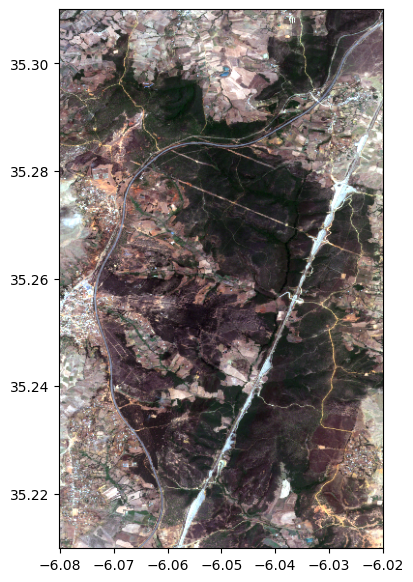

In [12]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# creating a figure 
fig, (ax1) = plt.subplots(1,1, figsize=(7,7))
fig.patch.set_facecolor('white')

# the downloaded file is float32 data format
# for plotting,  uint8 data format is needed

# plotting the image with full extent
pygge.easy_plot(thisfile, ax=ax1, bands=[3,2,1], percentiles=[0,99])



## False Colour Composite of before fire image of Larache

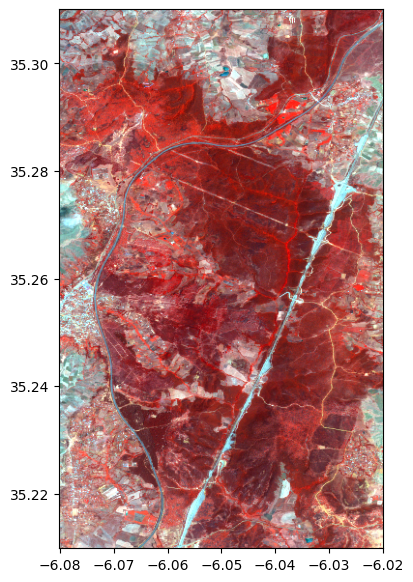

In [13]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# creating a figure with 2x3 subplots
fig, (ax1) = plt.subplots(1,1, figsize=(7,7))
fig.patch.set_facecolor('white')

# the downloaded file is float32 data format
# for plotting,  uint8 data format is needed

# plotting the image with full extent
pygge.easy_plot(thisfile, ax=ax1, bands=[4,2,1], percentiles=[0,99])



# Warping the downloaded before fire image composite of Larache into another map projection

The coordinate reference system (CRS) of the downloaded image composite is not in the UK national map projection. hence it is reprojected.

In [14]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# printing the EPSG code of our shapefile into which we want to reproject the TCI images
print("Reprojecting image to EPSG projection ", epsg)

# making a file name for the new file
warpfile = thisfile.split(sep='.')[0] + '_warped.tif'
print("We are in this directory: ")
!pwd
print("Input file: ", thisfile)
print("Output file: ", warpfile)

# calling the easy_warp function
tmp = pygge.easy_warp(thisfile, warpfile, epsg)

Reprojecting image to EPSG projection  4326
We are in this directory: 
/content/work/download


Input file:  s2.tif
Output file:  s2_warped.tif
Creating warped file:s2_warped.tif


# Plotting the shapefile on top of the raster

 To see the locations of our polygons on top of our image composite, we can do that with the Geopandas library.

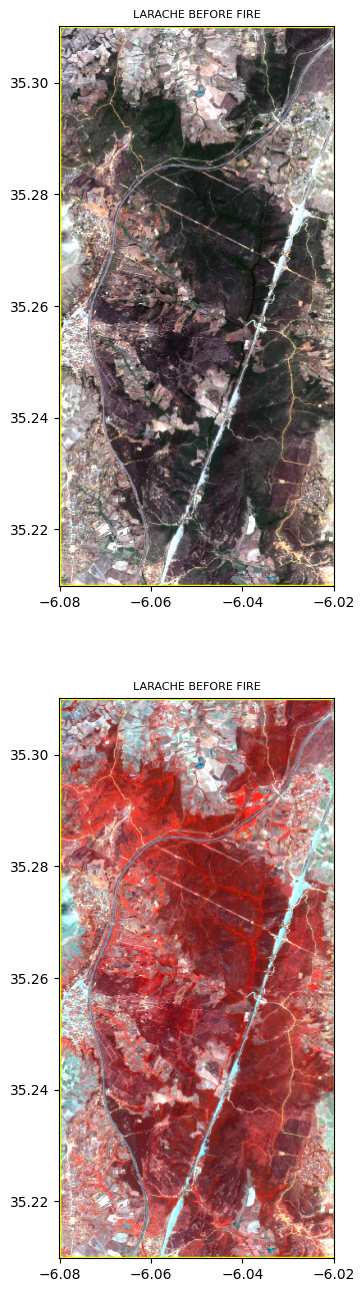

In [15]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# creating a figure with subplots
fig, ax = plt.subplots(2,1, figsize=(10,16))
fig.patch.set_facecolor('white')

# plotting the image with full extent in true colour
pygge.easy_plot(warpfile, ax=ax[0], percentiles=[0,98], bands=[3,2,1],
                shapefile=shapefile, fillcolor="none", linecolor="yellow", 
                title="LARACHE BEFORE FIRE")

# plotting the image with full extent in false colour
pygge.easy_plot(warpfile, ax=ax[1], percentiles=[0,98], bands=[4,2,1],
                shapefile=shapefile, fillcolor="none", linecolor="yellow", 
                title="LARACHE BEFORE FIRE")



# Defining the search parameters for the after fire image of Larache

We change the search dates to get a new image after the fire had burnt out. Fires were first reported on 15 July 2022

In [25]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# EDITing THE SEARCH OPTIONS BELOW

shapefile = join(rootdir, 'larache_shapefiles', 'FULL_POLYGON.shp') # ESRI Shapefile of the study area

# checking whether the shapefile exists
if os.path.exists(shapefile):
  print('Shapefile found: '+shapefile)
else:
  print('ERROR: Shapefile not found: '+shapefile)
  print('Upload a shapefile to your Google Drive directory: '+ rootdir)

# Defining a date range for the search
datefrom = '2022-07-30' # start date for imagery search
dateto   = '2022-08-05' # end date for imagery search
time_range = [datefrom, dateto] # format as a list

# Defining percentage cloud cover accepted in the images
clouds = 10 # maximum acceptable cloud cover in %

Shapefile found: /content/drive/MyDrive/satelliteCW1/larache_shapefiles/FULL_POLYGON.shp


Get some information about our shapefile.

In [27]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# Getting the shapefile layer's extent, CRS and EPSG code
extent, outSpatialRef, epsg = pygge.get_shp_extent(shapefile)
print("Extent of the area of interest (shapefile):\n", extent)
print(type(extent))
print("\nCoordinate referencing system (CRS) of the shapefile:\n", outSpatialRef)
print('EPSG code: ', epsg)

Extent of the area of interest (shapefile):
 (-6.08, -6.02, 35.21, 35.31)
<class 'tuple'>

Coordinate referencing system (CRS) of the shapefile:
 GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4326"]]
EPSG code:  4326


Getting the extent of the shapefile into a format that Google Earth Engine understands.


In [28]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# GEE needs a special format for defining an area of interest. 
# It has to be a GeoJSON Polygon and the coordinates should be first defined in a list and then converted using ee.Geometry. 
extent_list = list(extent)
print(extent_list)
print(type(extent_list))
# close the list of polygon coordinates by adding the starting node at the end again
# and make list elements in the form of coordinate pairs (y,x)
area_list = list([(extent[0], extent[2]),(extent[1], extent[2]),(extent[1], extent[3]),(extent[0], extent[3]),(extent[0], extent[2])])
print(area_list)
print(type(area_list))

search_area = ee.Geometry.Polygon(area_list)
print(search_area)
print(type(search_area))

[-6.08, -6.02, 35.21, 35.31]
<class 'list'>
[(-6.08, 35.21), (-6.02, 35.21), (-6.02, 35.31), (-6.08, 35.31), (-6.08, 35.21)]
<class 'list'>
ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -6.08,
              35.21
            ],
            [
              -6.02,
              35.21
            ],
            [
              -6.02,
              35.31
            ],
            [
              -6.08,
              35.31
            ],
            [
              -6.08,
              35.21
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})
<class 'ee.geometry.Geometry'>


Accessing the Sentinel-2 collection on Google Earth Engine and running the search. 

In [29]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# Obtain download links for image composites from an image collection on Google Earth Engine

# Name of the Sentinel 2 image collection
s2collection = ('COPERNICUS/S2')

# getting the median composite of Sentinel-2 images in the time range
s2median = pygge.obtain_image_sentinel(s2collection, time_range, search_area, clouds)

# Blue, Green,Red,NIR and SWIR are downloaded
bands = ['B2','B3','B4', 'B8','B12' ]
print(bands)

# spatial resolution of the downloaded data
resolution = 20 # in units of metres

# Downloading images in Geotiff, using the get_url(name, image, scale, region) method
# ‘region’ is obtained from the area, but the format has to be adjusted using get_region(geom) method
search_region = pygge.get_region(search_area)
s2url = pygge.get_url('s2', s2median.select(bands), resolution, search_region, filePerBand=False)
print(s2url)

['B2', 'B3', 'B4', 'B8', 'B12']
https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/3b62a644518dacef2cf989403d8c3e3f-44432a28d67b784f448895200db8318e:getPixels


# Downloading the data

The next cell downloads the image composite as a zip file and unzips it.

In [30]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# changing directory to download directory
os.chdir(downloaddir)

# requesting information on the file to be downloaded
f = pygge.requests.get(s2url, stream =True)

# checking whether it is a zip file
check = zipfile.is_zipfile(io.BytesIO(f.content))

# either download the file as is, or unzip it
while not check:
    f = requests.get(s2url, stream =True)
    check = zipfile.is_zipfile(io.BytesIO(f.content))
else:
    z = zipfile.ZipFile(io.BytesIO(f.content))
    z.extractall()

# Exploring the data directory structure of our downloaded files


In [31]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# where we stored the downloaded Sentinel-2 images
os.chdir(downloaddir)
print("contents of ", downloaddir, ":")
!ls -l

contents of  /content/work/download :
total 2200
-rw-r--r-- 1 root root 2251399 Apr 27 11:10 s2.tif


 the downloaded file is " s2.tif ".

the downloaded images are saved to a temporary directory that will be deleted when the virtual machine is closed. To save the images to my local directory, this is how it went;

I went to my Google Colab  folder in the panel on the left hand side.

Found the download directory and clicked on a Sentinel-2 image folder.

Right-clicked on it ,renamed it and selected 'download' to save it.

# Showing the after fire image of Larache as a colour composite




In [32]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# getting list of all tiff files in the directory
allfiles = [f for f in listdir(downloaddir) if isfile(join(downloaddir, f))]
print(allfiles)

# selecting the file for visualisation
thisfile = allfiles[0]
print(thisfile)

['s2.tif']
s2.tif


## True Colour composite of after fire image of Larache

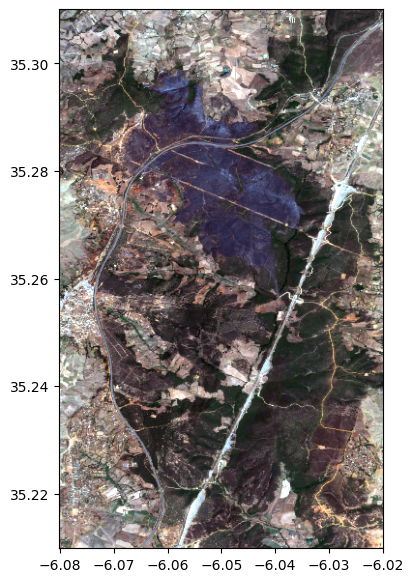

In [33]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# creating a figure with 2x3 subplots
fig, (ax1) = plt.subplots(1,1, figsize=(7,7))
fig.patch.set_facecolor('white')

# the downloaded file is float32 data format
# for plotting,  uint8 data format is needed

# plotting the image with full extent
pygge.easy_plot(thisfile, ax=ax1, bands=[3,2,1], percentiles=[0,99])



## False Colour Composite of after fire image of Larache

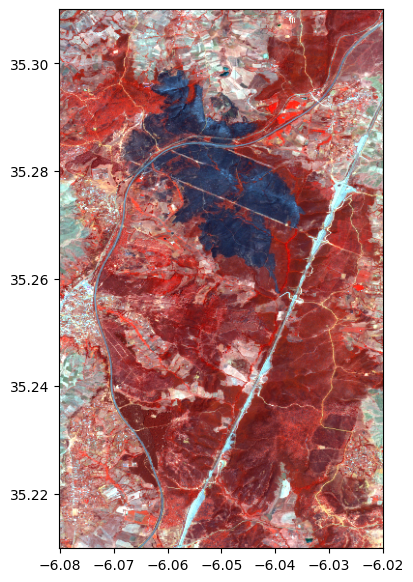

In [34]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# creating a figure with 2x3 subplots
fig, (ax1) = plt.subplots(1,1, figsize=(7,7))
fig.patch.set_facecolor('white')

# the downloaded file is float32 data format
# for plotting, we need uint8 data format

# plotting the image with full extent
pygge.easy_plot(thisfile, ax=ax1, bands=[4,2,1], percentiles=[0,99])



# Warping the downloaded after fire image composite of larache into another map projection

The coordinate reference system (CRS) of the downloaded image composite is not in the UK national map projection. It is reprojected.

In [35]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# printing the EPSG code of our shapefile into which we want to reproject the TCI images
print("Reprojecting image to EPSG projection ", epsg)

# making a file name for our new file
warpfile = thisfile.split(sep='.')[0] + '_warped.tif'
print("We are in this directory: ")
!pwd
print("Input file: ", thisfile)
print("Output file: ", warpfile)

# calling the easy_warp function
tmp = pygge.easy_warp(thisfile, warpfile, epsg)

Reprojecting image to EPSG projection  4326
We are in this directory: 
/content/work/download


Input file:  s2.tif
Output file:  s2_warped.tif
Creating warped file:s2_warped.tif


# Plotting the shapefile on top of the raster

to see the locations of our polygons on top of our image composite,We do that with the Geopandas library.

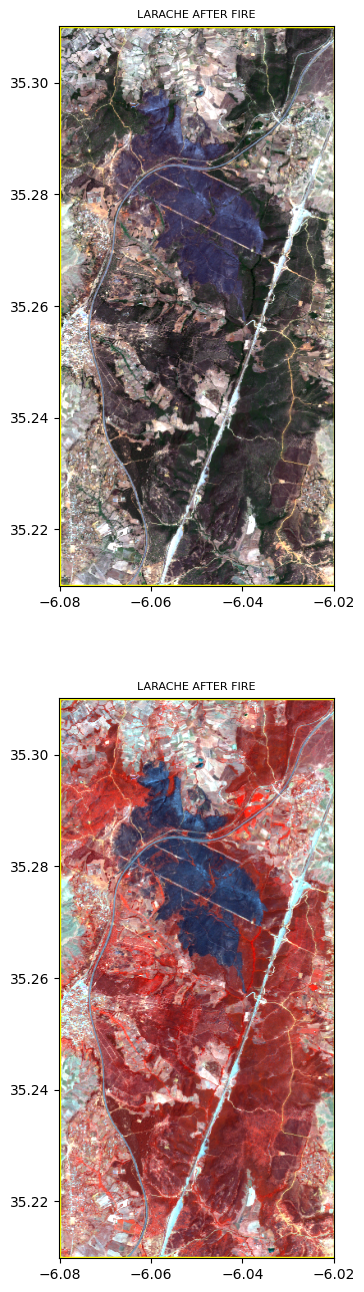

In [36]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# creating a figure with subplots
fig, ax = plt.subplots(2,1, figsize=(10,16))
fig.patch.set_facecolor('white')

# plotting the image with full extent
pygge.easy_plot(warpfile, ax=ax[0], percentiles=[0,98], bands=[3,2,1],
                shapefile=shapefile, fillcolor="none", linecolor="yellow", 
                title="LARACHE AFTER FIRE")

# plotting the image with full extent
pygge.easy_plot(warpfile, ax=ax[1], percentiles=[0,98], bands=[4,2,1],
                shapefile=shapefile, fillcolor="none", linecolor="yellow", 
                title="LARACHE AFTER FIRE")



                               

# READING IN DOWNLOADED TIF FILE OF LARACHE BEFORE FIRE AND GETTING ITS METADATA

In [37]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# reading in the warped before fire downloaded image of larache and checking its cordinate reference system
larache_before = rasterio.open(join(rootdir +  "/larache_before/before_fire_warped.tif"))
src1=larache_before
d1=src1.crs.to_wkt()
print(type(d1))
pprint(d1)


<class 'str'>
('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS '
 '84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')


# READING IN DOWNLOADED TIF FILE OF LARACHE AFTER FIRE AND GETTING ITS METADATA

In [38]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
# reading in the warped after fire downloaded image of larache and checking its cordinate system
larache_after = rasterio.open(join(rootdir +  "/larache_after/after_fire_warped.tif"))
src2=larache_after
d2=src2.crs.to_wkt()
print(type(d2))
pprint(d2)


<class 'str'>
('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS '
 '84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')


# CHECKING IF THE BEFORE AND AFTER DATASETS ARE OF SAME SHAPE

In [39]:
# checking if the before and after image data are the same shape?
larache_before.shape == larache_after.shape

True

# CALCULATION OF NBR FOR THE BEFORE FIRE IMAGE OF LARACHE

In [41]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
swir_before = larache_before.read(5) # band in position 5 in our stacked image i.e SWIR
nir_before = larache_before.read(4) # band in position 4 in our stacked image i.e NIR

# calculation of NBR before the fire as flaoting point array
nbr_before = (nir_before.astype(float) - swir_before.astype(float)) / (nir_before.astype(float) + swir_before.astype(float))


# Ignoring division by zero
np.seterr(divide='ignore', invalid='ignore')

# printing some image statistics, ignoring missing values (nan)
print("minimum NBR_before = ", np.nanmin(nbr_before))
print("mean NBR_before = ", np.nanmean(nbr_before))
print("maximum NBR_before = ", np.nanmax(nbr_before))
print("standard deviation = ", np.nanstd(nbr_before))



minimum NBR_before =  -0.14298390392538413
mean NBR_before =  0.10239791290152904
maximum NBR_before =  0.44895833342572644
standard deviation =  0.0735262823032699


## PLOT OF NBR BEFORE THE FIRE

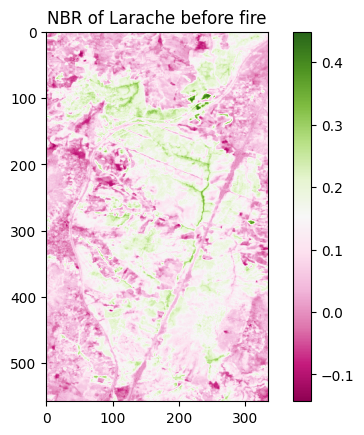

In [42]:
plt.imshow(nbr_before, cmap='PiYG')    # colours to use  include Purple and Green
plt.colorbar()
plt.title('NBR of Larache before fire')  # title of plot
plt.show()                               # plot


## CALCULATION OF NBR FOR THE AFTER FIRE IMAGE OF LARACHE

In [43]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
swir_after = larache_after.read(5) # band in position 5 in our stacked image i.e SWIR
nir_after = larache_after.read(4) # band in position 4 in our stacked image i.e NIR

# calculation of NBR after the fire as flaoting point array
nbr_after = (nir_after.astype(float) - swir_after.astype(float)) / (nir_after.astype(float) + swir_after.astype(float))

# Ignoring division by zero
np.seterr(divide='ignore', invalid='ignore')

# printing some image statistics, ignoring missing values (nan)
print("minimum NBR_after = ", np.nanmin(nbr_after))
print("mean NBR_after = ", np.nanmean(nbr_after))
print("maximum NBR_after = ", np.nanmax(nbr_after))
print("standard deviation = ", np.nanstd(nbr_after))


minimum NBR_after =  -0.3224225354386313
mean NBR_after =  0.049028595859026615
maximum NBR_after =  0.5460599474035327
standard deviation =  0.11624440093712922


## PLOT OF NBR AFTER THE FIRE

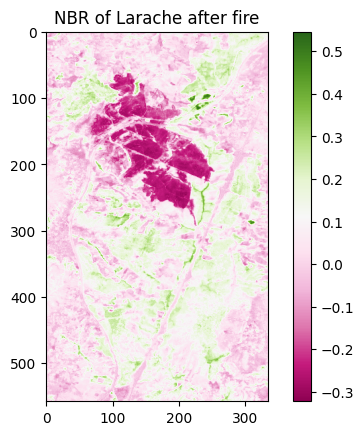

In [44]:
plt.imshow(nbr_after, cmap='PiYG') # Purple and Green selected as colours in plot
plt.colorbar()
plt.title('NBR of Larache after fire')  # title of plot
plt.show()                              # display plot or map


## CALCULATION OF dNBR AS DIFFERENCE OF BEFORE AND AFTER NBR RASTERS

In [45]:
# finding the difference between the NBR before and after the fire
dNBR = nbr_before - nbr_after

'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''

# printing some image statistics, ignoring missing values (nan)
print("minimum dNBR = ", np.nanmin(dNBR))
print("mean dNBR = ", np.nanmean(dNBR))
print("maximum dNBR = ", np.nanmax(dNBR))
print("standard deviation = ", np.nanstd(dNBR))


minimum dNBR =  -0.363571844669598
mean dNBR =  0.05336931704250243
maximum dNBR =  0.5638484811508442
standard deviation =  0.10752007563079775


## MAP SHOWING AREAS WHERE THE FIRE DAMAGE HAS BEEN GREATEST

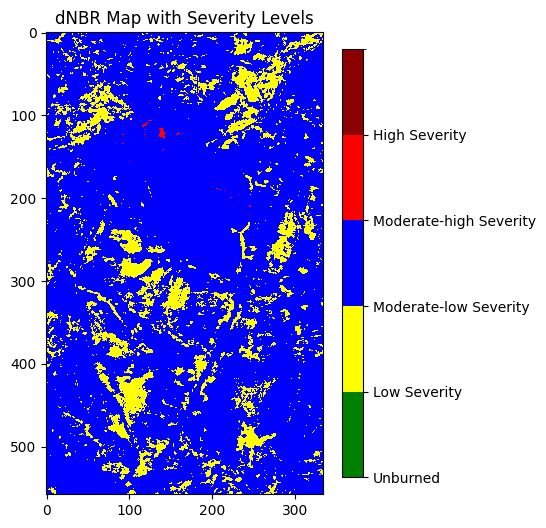

In [46]:


# Defining the dNBR values and the corresponding severity levels
dNBR

levels = [-1.0, -0.5, 0.0, 0.5, 1.0]
labels = ['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity']

# Creating a custom color map with 5 colors
cmap = colors.ListedColormap(['green', 'yellow', 'blue', 'red', 'darkred'])

# Setting the boundaries and norm of the color map
bounds = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(6, 6))

# Plotting the dNBR using the custom color map and norm
im = ax.imshow(dNBR, cmap=cmap, norm=norm)

# Adding a color bar with custom tick labels
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, boundaries=bounds, ticks=levels)
cbar.ax.set_yticklabels(labels)

# Setting the title and axis labels
ax.set_title('dNBR Map with Severity Levels')

plt.show()


## CALCULATION OF AREAS OF BURNED CLASSES USING dNBR

In [47]:
# Define the area of each pixel in hectares assuming a spatial resolution of 20 meters
pixel_area = 0.0004 

# Calculate the number of pixels in each class or label

unburned_pixels = np.sum((dNBR >= -1.0) & (dNBR < -0.5))
low_severity_pixels = np.sum((dNBR >= -0.5) & (dNBR < 0.0))
mod_low_severity_pixels = np.sum((dNBR >= 0.0) & (dNBR < 0.5))
mod_high_severity_pixels = np.sum((dNBR >= 0.5) & (dNBR < 1.0))
high_severity_pixels = np.sum(dNBR >= 1.0)

# Calculate the area of each class or label in hectares
unburned_area = unburned_pixels * pixel_area
low_severity_area = low_severity_pixels * pixel_area
mod_low_severity_area = mod_low_severity_pixels * pixel_area
mod_high_severity_area = mod_high_severity_pixels * pixel_area
high_severity_area = high_severity_pixels * pixel_area

# Print the area of each class or label
print('Unburned area:', unburned_area, 'hectares')
print('Low severity area:', low_severity_area, 'hectares')
print('Moderate-low severity area:', mod_low_severity_area, 'hectares')
print('Moderate-high severity area:', mod_high_severity_area, 'hectares')
print('High severity area:', high_severity_area, 'hectares')


Unburned area: 0.0 hectares
Low severity area: 12.1864 hectares
Moderate-low severity area: 62.4964 hectares
Moderate-high severity area: 0.0892 hectares
High severity area: 0.0 hectares


## CALCULATION OF AVERAGE NBR2 FOR BURNED POLYGON





In [48]:

# Opening the TIF file and the shapefile of burned polygon
with rasterio.open('/content/drive/MyDrive/satelliteCW1/larache_after/after_fire_warped.tif') as src:
    shapes = gpd.read_file('/content/drive/MyDrive/satelliteCW1/burned_layers/POLYGON.shp')

    # Masking the TIF file using the shapefile
    masked_data, _ = rasterio.mask.mask(src, shapes.geometry, crop=True)

    # Calculating the NBR2_burned
    # the NIR band has index 3 and SWIR band has index 4
    NBR2_burned = (masked_data[3] - masked_data[4]) / (masked_data[3] + masked_data[4])

    # Ignoring division by zero
np.seterr(divide='ignore', invalid='ignore')

# print average NBR2 for burned poloygon, ignoring missing values (nan)

print("average NBR2_burned = ", np.nanmean(NBR2_burned))


average NBR2_burned =  -0.13870606


## CALCULATION OF AVERAGE NBR1 FOR BURNED POLYGON





In [49]:

# Opening the TIF file and the shapefile of burned polygon
with rasterio.open('/content/drive/MyDrive/satelliteCW1/larache_before/before_fire_warped.tif') as src:
    shapes = gpd.read_file('/content/drive/MyDrive/satelliteCW1/burned_layers/POLYGON.shp')

    # Masking the TIF file using the shapefile
    masked_data, _ = rasterio.mask.mask(src, shapes.geometry, crop=True)

    # Calculating the NBR1_burned
    # the NIR  band has index 3 and SWIR band has index 4
    NBR1_burned = (masked_data[3] - masked_data[4]) / (masked_data[3] + masked_data[4])

    # Ignoring division by zero
np.seterr(divide='ignore', invalid='ignore')

# printing average NBR1 for burned polygon, ignoring missing values (nan)

print("average NBR1_burned = ", np.nanmean(NBR1_burned))


average NBR1_burned =  0.1715795


CALCULATION OF dNBR FOR BURNED POLYGON

In [50]:
#  finding the difference between the NBR before and after the fire
dNBR_burned = NBR1_burned - NBR2_burned

# printing average dNBR for burned polygon, ignoring missing values (nan)

print("average dNBR_burned = ", np.nanmean(dNBR_burned))


average dNBR_burned =  0.3102856


## CALCULATION OF AVERAGE NBR1 FOR UNBURNED POLYGON





In [51]:

# Opening the TIF file and the shapefile of unburned polygon
with rasterio.open('/content/drive/MyDrive/satelliteCW1/larache_before/before_fire_warped.tif') as src:
    shapes = gpd.read_file('/content/drive/MyDrive/satelliteCW1/unburned_layers/POLYGON.shp')

    # Masking the TIF file using the shapefile
    masked_data, _ = rasterio.mask.mask(src, shapes.geometry, crop=True)

    # Calculating the NBR1_unburned
    # the NIR band has index 3 and SWIR band has index 4
    NBR1_unburned = (masked_data[3] - masked_data[4]) / (masked_data[3] + masked_data[4])

    # Ignoring division by zero
np.seterr(divide='ignore', invalid='ignore')

# printing average NBR1 for unburned poloygon, ignoring missing values (nan)

print("average NBR1_unburned = ", np.nanmean(NBR1_unburned))


average NBR1_unburned =  0.17309634


## CALCULATION OF AVERAGE NBR2 FOR UNBURNED POLYGON





In [52]:

# Opening the TIF file and the shapefile of unburned polygon
with rasterio.open('/content/drive/MyDrive/satelliteCW1/larache_after/after_fire_warped.tif') as src:
    shapes = gpd.read_file('/content/drive/MyDrive/satelliteCW1/unburned_layers/POLYGON.shp')

    # Masking the TIF file using the shapefile
    masked_data, _ = rasterio.mask.mask(src, shapes.geometry, crop=True)

    # Calculating the NBR2_unburned
    # the NIR band has index 3 and SWIR band has index 4
    NBR2_unburned = (masked_data[3] - masked_data[4]) / (masked_data[3] + masked_data[4])

    # Ignoring division by zero
np.seterr(divide='ignore', invalid='ignore')

# printing average NBR2 for unburned poloygon, ignoring missing values (nan)

print("average NBR2_unburned = ", np.nanmean(NBR2_unburned))


average NBR2_unburned =  0.17163754


## CALCULATION OF dNBR FOR UNBURNED POLYGON

In [53]:
# finding the difference between the NBR before and after the fire
dNBR_unburned = NBR1_unburned - NBR2_unburned

# printing average dNBR for burned polygon, ignoring missing values (nan)

print("average dNBR_unburned = ", np.nanmean(dNBR_unburned))


average dNBR_unburned =  0.0014588113


## CALCULATION OF NDVI FOR THE BEFORE FIRE IMAGE OF LARACHE

In [54]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
r_before = larache_before.read(3) # band 3 in our stacked image is Red
nir_before = larache_before.read(4) # band 4 in our stacked image is NIR

# calculation of NDVI before the fire as flaoting point array
NDVI_before = (nir_before.astype(float) - r_before.astype(float)) / (nir_before.astype(float) + r_before.astype(float))

# Ignore division by zero
np.seterr(divide='ignore', invalid='ignore')

# print some image statistics, ignoring missing values (nan)
print("minimum NDVI_before = ", np.nanmin(NDVI_before))
print("mean NDVI_before = ", np.nanmean(NDVI_before))
print("maximum NDVI_before = ", np.nanmax(NDVI_before))
print("standard deviation = ", np.nanstd(NDVI_before))



minimum NDVI_before =  -0.0031236251459653844
mean NDVI_before =  0.16960801456931313
maximum NDVI_before =  0.44798869776436046
standard deviation =  0.053921411038247144


## CALCULATION OF NDVI FOR THE AFTER FIRE IMAGE OF LARACHE

In [55]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
r_after = larache_after.read(3) # band 3 in our stacked image is Red
nir_after = larache_after.read(4) # band 4 in our stacked image is NIR

# calculation of NDVI after the fire as flaoting point array
NDVI_after = (nir_after.astype(float) - r_after.astype(float)) / (nir_after.astype(float) + r_after.astype(float))

# Ignoring division by zero
np.seterr(divide='ignore', invalid='ignore')

# print some image statistics, ignoring missing values (nan)
print("minimum NDVI_after = ", np.nanmin(NDVI_after))
print("mean NDVI_after = ", np.nanmean(NDVI_after))
print("maximum NDVI_after = ", np.nanmax(NDVI_after))
print("standard deviation = ", np.nanstd(NDVI_after))


minimum NDVI_after =  -0.06513785137467486
mean NDVI_after =  0.17277971166410844
maximum NDVI_after =  0.5750123655099424
standard deviation =  0.07998356629775627


## MAPS OF NDVI BEFORE THE FIRE

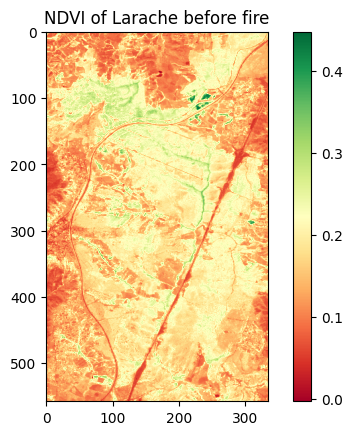

In [56]:
plt.imshow(NDVI_before, cmap='RdYlGn') # selection of Red to Green colours
plt.colorbar()                           # colour bar
plt.title('NDVI of Larache before fire')  # map title
plt.show()                                # showing plot


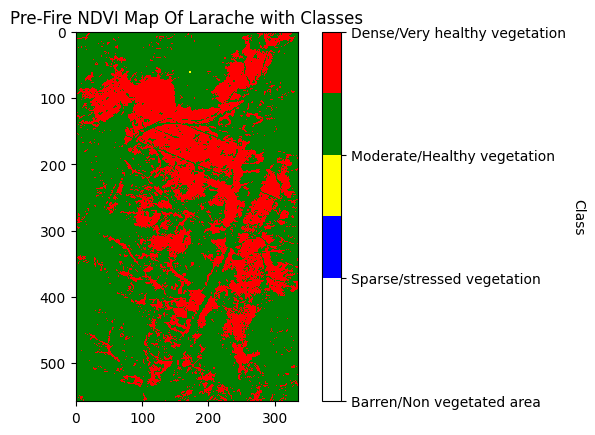

In [57]:


from matplotlib.colors import ListedColormap

# Assuming ndvi is a 2D array of NDVI values

# Define the classes and corresponding NDVI values
class_limits = [-1, 0, 0.2, 0.5, 1]
class_names = ['Barren/Non vegetated area', 'Sparse/stressed vegetation', 'Moderate/Healthy vegetation', 'Dense/Very healthy vegetation']
class_colors = [ 'blue', 'yellow',  'green', 'red']


# Create a new array to hold the class values
class_values = np.zeros(NDVI_before.shape, dtype=int)

# Assign each pixel in the NDVI array to a class
for i in range(len(class_limits)-1):
    class_values[(NDVI_before >= class_limits[i]) & (NDVI_before < class_limits[i+1])] = i+1

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the class values as an image with the corresponding colors
cmap = ListedColormap(class_colors)
im = ax.imshow(class_values, cmap=cmap)

# Add a legend to the plot
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Class', rotation=-90, va="bottom")
cbar.set_ticks(np.arange(len(class_names)))
cbar.set_ticklabels(class_names)



# Set the title of the plot
ax.set_title('Pre-Fire NDVI Map Of Larache with Classes')

plt.show()


MAPS OF NDVI AFTER THE FIRE

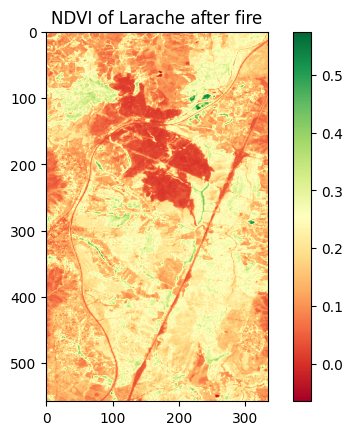

In [58]:
plt.imshow(NDVI_after, cmap='RdYlGn')      # Red to Green colour selected
plt.colorbar()
plt.title('NDVI of Larache after fire')    # title
plt.show()                                  


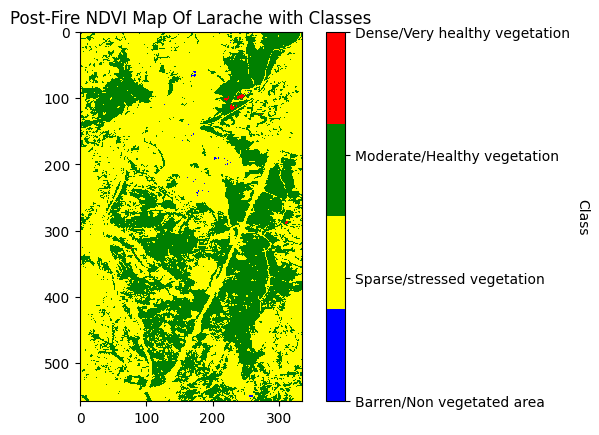

In [59]:

from matplotlib.colors import ListedColormap

# Assuming ndvi is a 2D array of NDVI values

# Define the classes and corresponding NDVI values
class_limits = [-1, 0, 0.2, 0.5, 1]
class_names = ['Barren/Non vegetated area', 'Sparse/stressed vegetation', 'Moderate/Healthy vegetation', 'Dense/Very healthy vegetation']
class_colors = [ 'blue', 'yellow',  'green', 'red']

# Create a new array to hold the class values
class_values = np.zeros(NDVI_after.shape, dtype=int)

# Assign each pixel in the NDVI array to a class
for i in range(len(class_limits)-1):
    class_values[(NDVI_after >= class_limits[i]) & (NDVI_after < class_limits[i+1])] = i

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the class values as an image with the corresponding colors
cmap = ListedColormap(class_colors)
im = ax.imshow(class_values, cmap=cmap)

# Add a legend to the plot
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Class', rotation=-90, va="bottom")
cbar.set_ticks(np.arange(len(class_names)))
cbar.set_ticklabels(class_names)


# Set the title of the plot
ax.set_title('Post-Fire NDVI Map Of Larache with Classes')

plt.show()


## CALCULATING THE NDVI DIFFERENCE (dNDVI)

In [60]:
# finding the difference between the NDVI before and after the fire
dNDVI = NDVI_before - NDVI_after

'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''

# printing some image statistics, ignoring missing values (nan)
print("minimum dNDVI = ", np.nanmin(dNDVI))
print("mean dNDVI = ", np.nanmean(dNDVI))
print("maximum dNDVI = ", np.nanmax(dNDVI))
print("standard deviation = ", np.nanstd(dNDVI))

minimum dNDVI =  -0.3098725340997325
mean dNDVI =  -0.0031716970947953077
maximum dNDVI =  0.33930637628747506
standard deviation =  0.06478898685069448


## dNDVI based BURN SEVERITY MAP

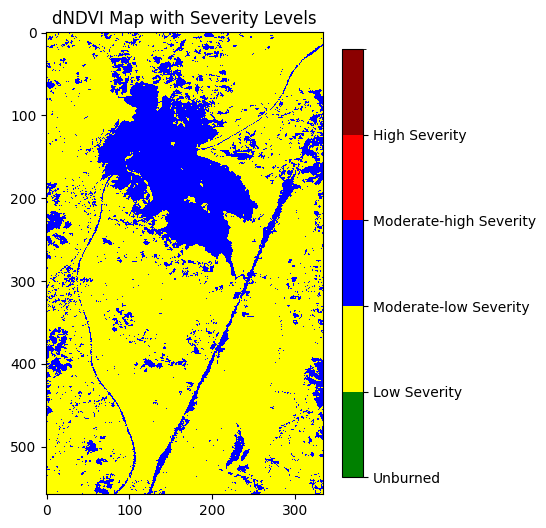

In [61]:


# Defining the dNDVI values and the corresponding severity levels
dNDVI

levels = [-1.0, -0.5, 0.0, 0.5, 1.0]
labels = ['Unburned', 'Low Severity', 'Moderate-low Severity', 'Moderate-high Severity', 'High Severity']

# Creating a custom color map with 5 colors
cmap = colors.ListedColormap(['green', 'yellow', 'blue', 'red', 'darkred'])

# Setting the boundaries and norm of the color map
bounds = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Creating a figure and axis object
fig, ax = plt.subplots(figsize=(6, 6))

# Plotting the dNDVI using the custom color map and norm
im = ax.imshow(dNDVI, cmap=cmap, norm=norm)

# Adding a color bar with custom tick labels
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, boundaries=bounds, ticks=levels)
cbar.ax.set_yticklabels(labels)

# Setting the title and axis labels
ax.set_title('dNDVI Map with Severity Levels')

plt.show()


## CALCULATION OF BURNED AREAS BASED ON dNDVI

In [62]:
# Define the area of each pixel in hectares assuming a spatial resolution of 20 meters
pixel_area = 0.0004 

# Calculate the number of pixels in each class or label

unburned_pixels = np.sum((dNDVI >= -1.0) & (dNDVI < -0.5))
low_severity_pixels = np.sum((dNDVI >= -0.5) & (dNDVI < 0.0))
mod_low_severity_pixels = np.sum((dNDVI >= 0.0) & (dNDVI < 0.5))
mod_high_severity_pixels = np.sum((dNDVI >= 0.5) & (dNDVI < 1.0))
high_severity_pixels = np.sum(dNDVI >= 1.0)

# Calculate the area of each class or label in hectares
unburned_area = unburned_pixels * pixel_area
low_severity_area = low_severity_pixels * pixel_area
mod_low_severity_area = mod_low_severity_pixels * pixel_area
mod_high_severity_area = mod_high_severity_pixels * pixel_area
high_severity_area = high_severity_pixels * pixel_area

# Print the area of each class or label
print('Unburned area:', unburned_area, 'hectares')
print('Low severity area:', low_severity_area, 'hectares')
print('Moderate-low severity area:', mod_low_severity_area, 'hectares')
print('Moderate-high severity area:', mod_high_severity_area, 'hectares')
print('High severity area:', high_severity_area, 'hectares')


Unburned area: 0.0 hectares
Low severity area: 57.064800000000005 hectares
Moderate-low severity area: 17.7072 hectares
Moderate-high severity area: 0.0 hectares
High severity area: 0.0 hectares


## TESTING WHETHER THE dNBR WAS CORRELATED TO  dNDVI

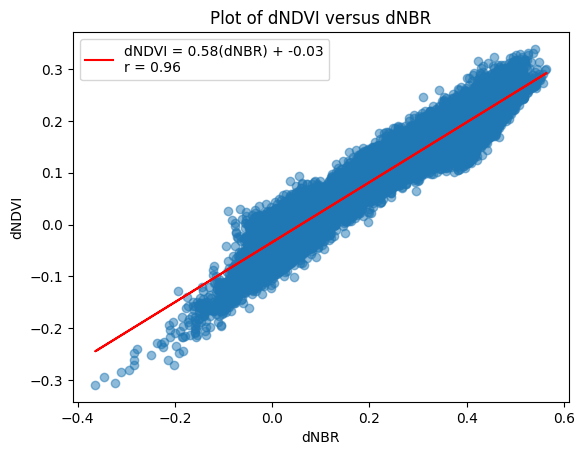

In [63]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Assuming dNBR and dNDVI are 2D arrays with the same shape
dNBR_flat = dNBR.flatten()
dNDVI_flat = dNDVI.flatten()

# Calculate the linear regression line
slope, intercept, r_value, p_value, std_err = linregress(dNBR_flat, dNDVI_flat)
line = slope * dNBR_flat + intercept

# Create a scatter plot
fig, ax = plt.subplots()
ax.scatter(dNBR_flat, dNDVI_flat, alpha=0.5)

# Add the linear regression line to the scatter plot with the equation and correlation coefficient
eqn_label = f'dNDVI = {slope:.2f}(dNBR) + {intercept:.2f}'
corr_label = f'r = {r_value:.2f}'
ax.plot(dNBR_flat, line, color='red', label=f'{eqn_label}\n{corr_label}')

# Set the x-axis and y-axis labels
ax.set_xlabel('dNBR')
ax.set_ylabel('dNDVI')

# Set the title of the plot
ax.set_title('Plot of dNDVI versus dNBR')

# Add the legend to the plot
ax.legend()

plt.show()


In [1]:
'''
--------------------------------------------------------------
The following block of code originates and is modified from:

Balzter, H. (2023)
Materials for GY7709 masters computer classes.
https://uniofleicester-my.sharepoint.com/personal/hb91_leicester_ac_uk/_layouts/15
/onedrive.aspx?id=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%2FGY7709%5FSatellite%5FData%5FAnalysis%
5Fin%5FPython%2F2022%2D23%2FGY7709%2D2022%2D23%2Ezip&parent=%2Fpersonal%2Fhb91%5Fleicester%5Fac%5Fuk%2FDocuments%2FDesktop%
2FGY7709%5FSatellite%5FData%5FAnalysis%5Fin%5FPython%2F2022%2D23&ga=1
Downloaded 1 February 2023
--------------------------------------------------------------
'''
#To save a notebook as an html file, i add a new code cell at the end of the notebook with the following contents:
!pip install -U notebook-as-pdf
!pyppeteer-install
!jupyter nbconvert /content/drive/MyDrive/satelliteCW1/229010645_GY7709_CW1.ipynb --to html
 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.8 MB/s eta 0:00:00
[INFO] Starting Chromium download.
100% 109M/109M [00:00<00:00, 268Mb/s]
[INFO] Beginning extraction
[INFO] Chromium extracted to: /root/.local/share/pyppeteer/local-chromium/588429
[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/satelliteCW1/229010645_GY7709_CW1.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.